# Creating Customer Segments

> Creating customer segments based on their annual spending on various product categories

> Project taken from Udacity course: Machine Learning Nanodegree

> Author: Menghan Xu

> Date: 2016-09-01

### Importing the data and initial checks

In [83]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display

%matplotlib inline

# Load the wholesale customers dataset
try:
    raw = pd.read_csv("customers.csv")
    data = raw.drop(['Region', 'Channel'], axis = 1)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

In [84]:
print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
data.describe()

Wholesale customers dataset has 440 samples with 6 features each.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


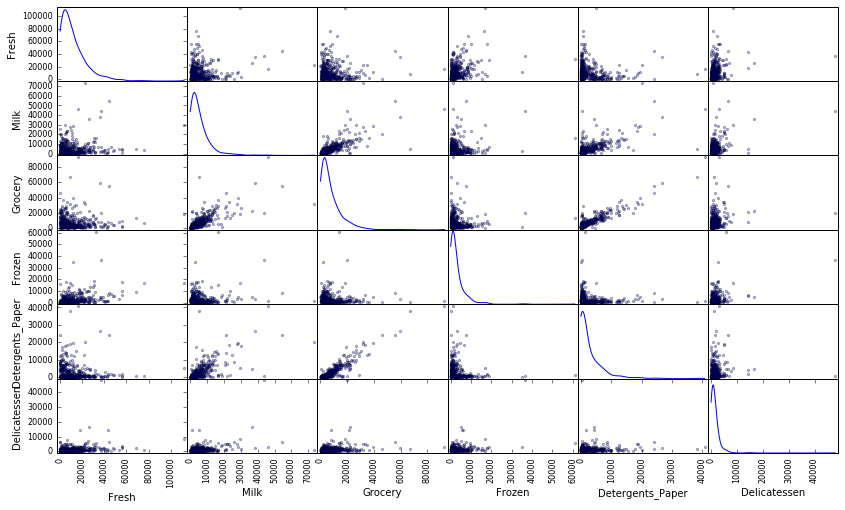

In [85]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### As we can see all of the spending variables are highly skewed towards the left, so we take the logarithm of each.

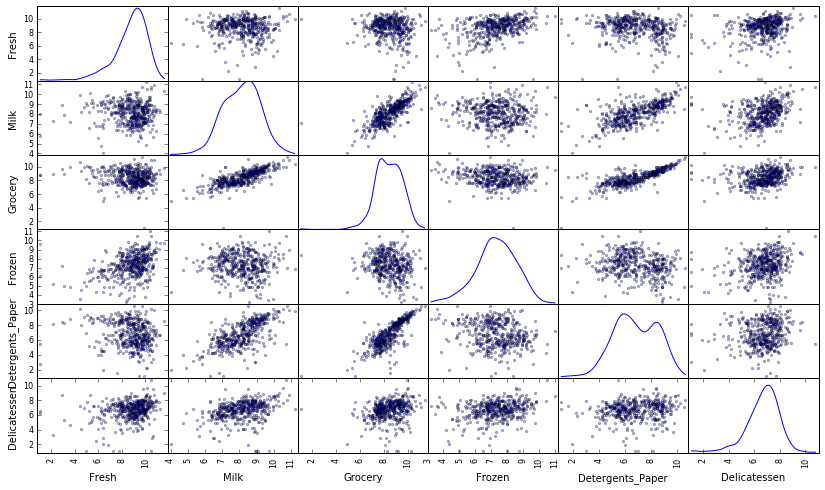

In [86]:
# Scale the data using the natural logarithm
log_data = data.applymap(np.log)
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612


(440, 6)
(435, 6)


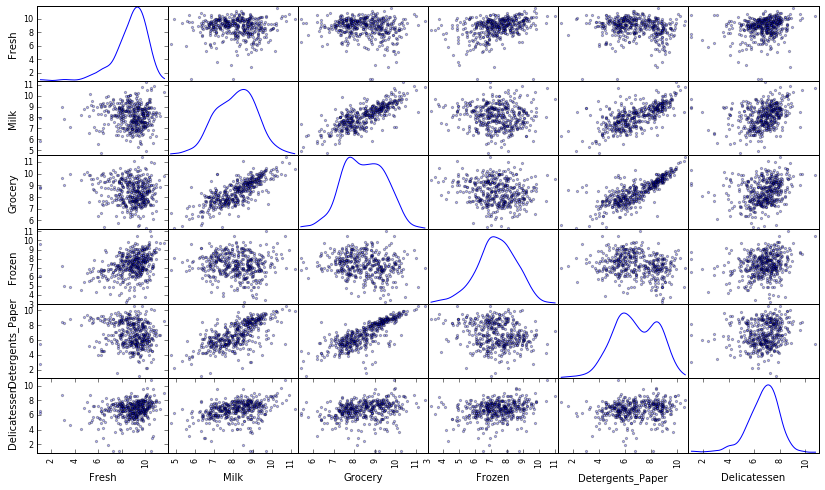

In [87]:
# list of potential outliers to examine
potentials = pd.DataFrame([])

# For each feature find the data points with extreme high or low values using Tukey's method
for feature in log_data.keys():

    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    step = (Q3-Q1)  # a measure of variability   
    # how far each obs is from either Q1 or Q3, normalized by step
    distance = [(Q1-x)/step if x < Q1 else (x-Q3)/step if x > Q3 else 0 for x in log_data[feature]]
    
    potentials = potentials.append(log_data.loc[np.array(distance) >= 1.5])

# choose the ones that have appeared twice or more in this list
outliers = potentials.loc[potentials.duplicated(keep=False)]
display(outliers)

# Remove the outliers
print log_data.shape
good_data = log_data.loc[[False if x in outliers.index else True for x in log_data.index]].reset_index(drop = True)
print good_data.shape

# replot scatter plot to make sure the data appears more spread out
pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### According to the plots, there seems to be considerable correlation among some variables. Perform PCA to extract the most important latent variables

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197


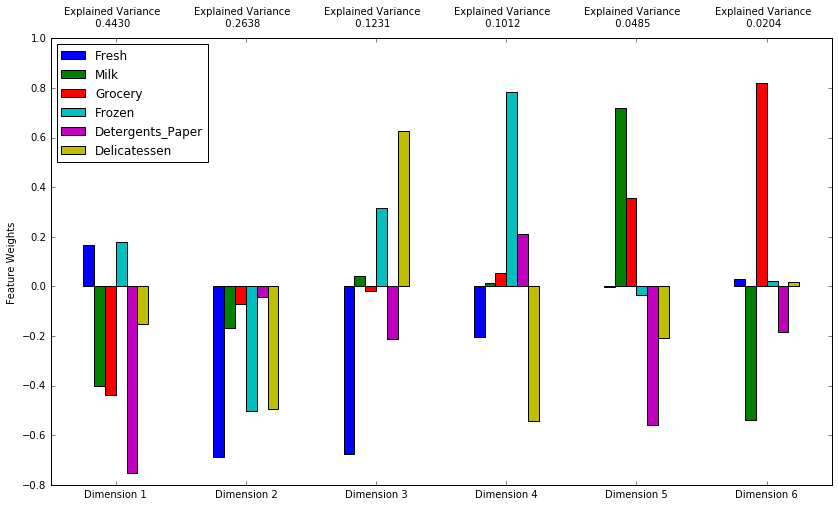

In [88]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(good_data)

# renders is a library provided to us by Udacity
# it deals specifically with visualization for this project
# Generate PCA results plot
rs.pca_results(good_data, pca)

In [89]:
# the first 2 dimensions already explains 70% of variance, which is enough for this purpose
pca = PCA(n_components=2)
reduced_data = pd.DataFrame(pca.fit_transform(good_data), columns = ['Dimension 1', 'Dimension 2'])

In [90]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Try several 'k's to find one that yields the largest silhouette score and lowest bic
for k in range(2,6):
    clusterer = GaussianMixture(n_components=k, n_init=20)
    clusterer.fit(reduced_data)

    preds = clusterer.predict(reduced_data)
    score = silhouette_score(reduced_data, preds)
    
    bic = clusterer.bic(reduced_data)
    
    print "When number of clusters is {}: silhouette score {:.2f}, BIC {:.2f}".format(k, score, bic)


When number of clusters is 2: silhouette score 0.42, BIC 3566.64
When number of clusters is 3: silhouette score 0.39, BIC 3577.18
When number of clusters is 4: silhouette score 0.35, BIC 3587.94
When number of clusters is 5: silhouette score 0.31, BIC 3590.41


### When number of clusters is 2, the silhoutte score is highest and BIC score is lowest.

### Plot the clusters and their centers
### Note the following code is borrowed heavily from Udacity's renders library

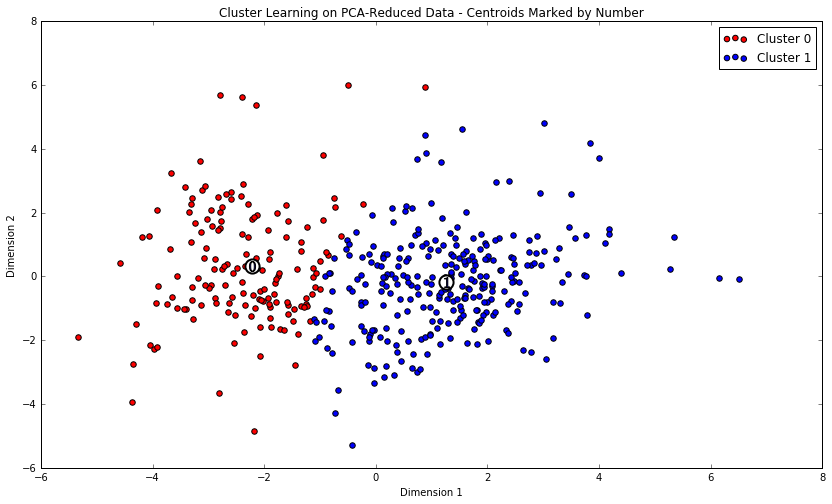

In [91]:
import pylab as plt

clusterer = GaussianMixture(n_components=2, n_init=20)
clusterer.fit(reduced_data)


plot_data = reduced_data
plot_data['Cluster'] = clusterer.predict(reduced_data)
centers = clusterer.means_                                              

fig, ax = plt.subplots(figsize = (14,8))
colors = ['r','b','g','y'] # colors each cluster get, can handle at most 4 clusters

# Color the points based on assigned cluster
for i, cluster in plot_data.groupby('Cluster'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                 color = colors[i], label = 'Cluster %i'%(i), s=30);

# Plot centers with indicators
for i, c in enumerate(centers):
    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
               alpha = 1, linewidth = 2, marker = 'o', s=200);
    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

# Set plot title
ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number");
